# 에이전트 대화 시뮬레이션 - 고객 응대 시나리오

고객 지원 어시스턴트의 경우, 챗봇의 성능을 평가하는 것이 어려울 수 있습니다.   
코드 변경마다 수동으로 테스트 하는것은 시간이 많이 소요됩니다.   
평가 과정을 더 쉽고 재현 가능하게 만드는 한가지 방법은 사용자 상호작용을 시뮬레이션 하는것 입니다.   



In [1]:
from dotenv import load_dotenv 
import sys
import os

# Add the project root directory (parent of src) to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

load_dotenv()

from config.langsmith import langsmith 

langsmith(project_name="LangGraph-Agent-Simulation", set_enable=True)

from langgraph.graph.message import add_messages
from typing import Annotated 
from typing_extensions import TypedDict 

class State(TypedDict):
    messages: Annotated[list, add_messages]

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Agent-Simulation


## 상담사, 고객 역할 정의 

### 상담사 역할 정의 
* 시뮬레이션에서 상담사 역할을 하는 챗봇 정의 

**참고**
* `call_chatbot` 내의 구현은 설정 가능하며, 내부에서 사용한 모델을 Agent로 변경하는 것도 가능합니다. 
* `call_chatbot` 은 사용자로부터 메시지를 입력으로 받아, 고객을 상담하는 역할을 부여하겠습니다. 

In [2]:
from typing import List 
# from langchain_google_vertexai import ChatVertexAI  # vertex ai사용시 
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage 
from langchain_core.output_parsers import StrOutputParser 
from langchain_google_genai import ChatGoogleGenerativeAI # google genai사용시 

def call_chatbot(messages: List[BaseMessage]) -> dict:
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a customer support agent for an airline. Answer in Korean."
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    model = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash-001",
        temperature=0.0,
        max_tokens=4096,
        google_api_key=os.getenv("GEMINI_API_KEY"),
    )
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages": messages})




## 고객 역할 정의 (simulated user)

시뮬레이션 된 고객의 역할을 정의합니다. 고객 지원 시나리오에서의 대화를 시뮬레이션 합니다.   
시스템 프롬프트는 고객과 고객 지원 담당자간의 상호작용을 설정하며, 사용자 지시사항을 통해 시나리오의 세부 사항을 제공합니다.  
이 구성은 특정 사용자 요구 (예 : 환불 요청) 에 대한 모델의 반응을 시뮬레이션 하는데 사용됩니다. 

In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder 

def create_scenario(name: str, instructions: str):
    # 시스템 프롬프트 정의 : 필요에 따라 변경 
    systemp_prompt_template = """ 
    You are a customer of  an airline company. You are interacting with a user who is a customer support person. 

    Your name is {name}.

    # Instructions : 
    {instructions}

    [Important]
    - When you are finished with the conversation, respond with a single word 'FINISHED'.
    - You must speak in Korean.
    """

    # 대화 메시지와 시스템 프롬프트를 결합하여 채팅 프롬프트 템플릿을 생성합니다. 
    # 사용자 프롬프트 정의 : 시나리오 설명 
    user_prompt_template = """ 
    {name} is a {instructions}. 
    """
    # 프롬프트 템플릿 생성 
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", systemp_prompt_template),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt 


In [4]:
# 가상 시나리오 생성 (고객입장)
# 사용자 지시사항 설정 
instructions = """ 
    You are trying to get a refund for the trip you took to Jeju Island. 
    You want them to give you ALL the money back. 
    This trip happened last year
"""

# 사용자 이름 정의 
name = "Teddy"

create_scenario(name, instructions).pretty_print() 


================================ System Message ================================

 
    You are a customer of  an airline company. You are interacting with a user who is a customer support person. 

    Your name is {name}.

    # Instructions : 
    {instructions}

    [Important]
    - When you are finished with the conversation, respond with a single word 'FINISHED'.
    - You must speak in Korean.
    

============================= Messages Placeholder =============================

{messages}


In [5]:
# from langchain_google_vertexai import ChatVertexAI 
from langchain_google_genai import ChatGoogleGenerativeAI

# 챗봇 모델 초기화
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0.0,
    max_tokens=4096,
    google_api_key=os.getenv("GEMINI_API_KEY"),
)

# 시뮬레이션된 사용자 대화 생성 
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()

In [6]:
# simulated_user 를 호출하여 시뮬레이션 된 사용자에게 메시지를 전달. 

# 시뮬레이션된 사용자에게 메시지를 전달 
messages = [HumanMessage(content="안녕하세요? 무엇을 도와드릴까요?")]

simulated_user.invoke({"messages": messages})

'안녕하세요. 작년에 제주도 갔던 비행기표 환불받고 싶어서 전화했어요.'

## 에이전트 시뮬레이션 정의하기 

In [7]:
""" 
노드 정의
* 메시지 목록을 입력으로 받아 상태에 추가할 메시지 목록을 반환해야 합니다. 
챗봇과 시뮬레이션된 사용자를 둘러싼 것 래퍼들입니다. 
"""

from langchain_core.messages import AIMessage 

# 상담사 역할
def ai_assistant_node(messages):
    # 상담사 응답 호출
    ai_response = call_chatbot(messages)
    
    # AI 상담사의 응답을 반환 
    return {"messages": [("assistant", ai_response)]}


In [8]:

# 상담사 역할 노드 호출 
ai_assistant_node(
    [
        ("user", "안녕하세요?"),
        ("assistant", "안녕하세요! 무엇을 도와드릴까요?"),
        ("user", "환불하고싶어요."),
    ]
)

{'messages': [('assistant',
   '환불을 원하시는군요. 예약 번호 또는 항공권 번호를 알려주시겠어요? 환불 규정은 항공권 종류에 따라 다르기 때문에, 정확한 정보를 확인해야 합니다. 또한, 환불 사유도 말씀해주시면 더 자세한 안내를 도와드릴 수 있습니다.')]}

In [16]:
def _swap_roles(messages):
    # 메세지의 역할을 교환: 시뮬레이션 사용자 단계에서 메시지 타입을 AI -> Human, Human -> AI로 교환 
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # AIMessage 인 경우 HumanMessage로 변환 
            new_messages.append(HumanMessage(content=m.content))
        else:
            # HumanMessage 인 경우 AIMessage로 변환 
            new_messages.append(AIMessage(content=m.content))
    return new_messages

# 상담사 역할 노드 정의 
def ai_assistant_node(state:State):
    # 상담사 응답 반환
    ai_response = call_chatbot(state["messages"])
    # AI 상담사 응답을 반환 
    return {"messages": [("assistant", ai_response)]}

# 시뮬레이션된 사용자 노드 정의
def simulated_user_node(state:State):
    # 메시지 타입을 교환 : AI -> Human, Human -> AI
    new_messages = _swap_roles(state["messages"])
    # 시뮬레이션된 사용자를 호출
    response = simulated_user.invoke({"messages":new_messages})
    return {"messages": [("user", response)]}



## 엣지 정의 


In [17]:
"""
엣지 정의 
* 시뮬레이션된 사용자가 작업을 마친 후 발생하며, 두가지 결과 중 하나로 이어져야함. 
-> 고객 지원 봇을 호출하여 계속 진행 ("continue")
-> 대화를 마치고 종료 ("end")

* 대화 종료 로직
-> 인간 챗봇이 FINISHED 라는 단어를 반환하면 대화가 종료
-> 대화가 6개 메시지를 초과하는 경우 대화가 종료
"""

# 대화 종료 엣지 정의 
def should_continue(state:State):
    # 대화가 6개 메시지를 초과하는 경우 대화가 종료
    if len(state["messages"]) > 6:
        return "end"
    # 인간 챗봇이 FINISHED 라는 단어를 반환하면 대화가 종료
    elif state["messages"][-1].content == "FINISHED":
        return "end"
    # 위 조건에 해당되지 않으면 대화가 계속됨
    else:
        return "continue"


## 그래프 정의

In [18]:
""" 
시뮬레이션을 설정하는 그래프 정의
"""

from langgraph.graph import END, StateGraph 

# StateGraph 인스턴스 생성
graph_builder = StateGraph(State)

#노드 정의
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# 엣지 정의 (챗봇 -> 시뮬레이션된 사용자)
graph_builder.add_edge("ai_assistant", "simulated_user")

# 조건부 엣지 정의
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end" : END,
        "continue" : "ai_assistant",
    },
)

# 시작점 설정 
graph_builder.set_entry_point("ai_assistant")

# 그래프 컴파일
simulation = graph_builder.compile()

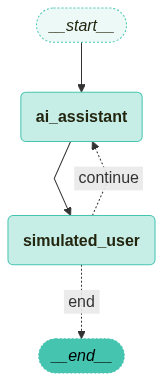

In [19]:
from config.graphs import visualize_graph

visualize_graph(simulation)

## 시뮬레이션 시작

In [20]:
from langchain_core.runnables import RunnableConfig
from config.messages import stream_graph, random_uuid

config = RunnableConfig(
    recursion_limit=10,
    configurable = {"thread_id": random_uuid()},
)

inputs = {
    "messages" : [
        HumanMessage(content="안녕하세요? 저 지금 화가 많이 났습니다.")
    ]
}

# 그래프 스트리밍
stream_graph(
    simulation,
    inputs,
    config,
    node_names=["simulated_user","ai_assistant"]
)




🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요. 불편을 드려 정말 죄송합니다. 어떤 일 때문에 화가 나셨는지 자세히 말씀해주시면 최선을 다해 도와드리겠습니다. 무슨 일이 있었는지 말씀해주시겠어요?

🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
작년에 제주도 갔던 비행기 말인데요, 그거 전부 환불받고 싶습니다.

🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
작년에 제주도행 항공편에 문제가 있으셨군요. 환불을 원하시는 이유를 좀 더 자세히 말씀해주시겠어요? 어떤 점이 불편하셨는지, 그리고 예약 정보 (예약 번호, 항공편 번호, 탑승자 이름 등)를 알려주시면 환불 규정을 확인하고 도와드리겠습니다. 최대한 빨리 해결해 드릴 수 있도록 노력하겠습니다.

🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
아니, 이유가 뭐가 중요해요? 어쨌든 비행기 탔었고, 지금 환불받고 싶다고요. 예약 번호는 기억 안 나고, 제 이름은 테디입니다. 작년에 제주도 간 거, 그거 전부 환불해주세요. 전부 다!

🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
테디 고객님, 불편하신 마음은 충분히 이해합니다. 다만, 환불을 진행하려면 예약 확인이 필요합니다. 예약 번호를 모르시는 경우, 몇 가지 추가 정보를 여쭤봐도 될까요?

*   **정확한 탑승 날짜 (예: 2023년 5월 15일)**
*   **출발지와 도착지 (예: 서울 - 제주)**
*   **함께 탑승하신 분이 있다면 성함**

이 정보들을 토대로 예약 내역을 찾아보고, 환불 가능 여부와 절